# Set Up

In [1]:
# Reviews CSV
%%capture
!wget https://www.dropbox.com/scl/fi/6u1yfcnnf4jqmhedx519u/reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6&st=ko3q9dnq&dl=0
!mv reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6 reviews.csv
# Reviews images related
!wget https://www.dropbox.com/scl/fi/2o3fmzj4jdsfujfhu0mns/reviews.zip?rlkey=yc8doasvaavp2993huknxw6jt&st=3e3bpy5q&dl=0
!mv reviews.zip?rlkey=yc8doasvaavp2993huknxw6jt reviews.zip
!unzip reviews.zip
# Metadata for each restaurant
!wget https://www.dropbox.com/scl/fi/cxckzuj81gsnlsvclqnza/metadata.json.gz?rlkey=d4xerrcwbeyt09oi01f9f4wru&st=sv6cnpzh&dl=0
!mv metadata.json.gz?rlkey=d4xerrcwbeyt09oi01f9f4wru metadata.json.gz
# Tiny LLaVa Descriptions
!wget https://www.dropbox.com/scl/fi/50pmwvytozpz0cl1p054f/tiny_LLaVa_images_descriptions.json.gz?rlkey=7vreygmtd16lohs3bx6yvmwdk&st=9568qz84&dl=0
!mv tiny_LLaVa_images_descriptions.json.gz?rlkey=7vreygmtd16lohs3bx6yvmwdk tiny_LLaVa_images_descriptions.json.gz
# Restaurants CSV
!wget https://www.dropbox.com/scl/fi/g8862obe2z29su61popjx/restaurants.csv?rlkey=rhrn6vg0zg6ier2yuz9lh00yh&st=tqfdpqjv&dl=0
!mv restaurants.csv?rlkey=rhrn6vg0zg6ier2yuz9lh00yh restaurants.csv

# Libraries

In [12]:
%%capture
!pip install --upgrade -q accelerate bitsandbytes
!pip install accelerate
!pip install pyreclab
!pip install cornac
!pip install pali-torch
!pip install einops torchvision
!pip install lightFM --upgrade
import pandas as pd
import numpy as np
import json
import gzip
import pyreclab
import random
from sklearn.model_selection import train_test_split
import scipy.sparse as sparse
import os
# images
from keras.applications import vgg16, vgg19, ResNet50
from tensorflow.keras.utils import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
# text
import requests
import heapq
import math
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from io import BytesIO
import pickle
import time
# cornac
import cornac
from cornac.data import Reader, Dataset
import cornac.datasets
from cornac.eval_methods import RatioSplit
from cornac.data import TextModality, ImageModality
from cornac.data.text import BaseTokenizer
from cornac.models import PMF, SoRec, WMF, CTR, BPR, VBPR, DMRL, AMR
import torch
# SBert
from sentence_transformers import SentenceTransformer
from concurrent.futures import ThreadPoolExecutor
# LightFM
from lightfm import LightFM
from lightfm.data import Dataset
import lightfm.evaluation as lightfm_eval
from lightfm.evaluation import auc_score
# ...
from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers import BitsAndBytesConfig
import torch
from tqdm import tqdm
from collections import Counter
from itertools import combinations
from scipy.sparse import csr_matrix

In [79]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader
from torchvision import transforms
import spacy
import seaborn as sns
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# Data Preprocessing

In [13]:
df = pd.read_csv('reviews.csv')
print(f"Tamaño dataset: {df.shape}")

count_per_state = df['state'].value_counts()
for state, count in count_per_state.items():
    folder_size = len(os.listdir(f'reviews/{state}'))
    print(f"State: {state}, Count: {count}")
    print(f"Folder size {folder_size}")
    if folder_size >= count:
        print('- Se encuentran todas las imagenes => No hay conflictos\n')
    else:
        print('- Hay que eliminar imagenes => Conflicto\n')
        for row in df.itertuples():
            img_filename = row.img_filename
            path = f'{row.gmap_id}.png'
            state = row.state
            if path not in os.listdir(f'reviews/{state}'):
                print(row)

# Eliminamos datos nulos ...
df = df.dropna()


Tamaño dataset: (8334, 9)
State: Virginia, Count: 2881
Folder size 2948
- Se encuentran todas las imagenes => No hay conflictos

State: California, Count: 1775
Folder size 1775
- Se encuentran todas las imagenes => No hay conflictos

State: Texas, Count: 1134
Folder size 1134
- Se encuentran todas las imagenes => No hay conflictos

State: Hawaii, Count: 984
Folder size 984
- Se encuentran todas las imagenes => No hay conflictos

State: Florida, Count: 912
Folder size 912
- Se encuentran todas las imagenes => No hay conflictos

State: North_Dakota, Count: 648
Folder size 678
- Se encuentran todas las imagenes => No hay conflictos



In [14]:
X = df[['user_id', 'rest_id', 'rating']]

In [15]:
restaurants = pd.read_csv('restaurants.csv')


categories = restaurants['categories'].unique()
categ2idx = {categ : idx for idx, categ in enumerate(categories)}
idx2categ = {idx : categ for categ, idx in categ2idx.items()}


restaurants_lst = list(restaurants.iterrows())


X_categories = []
for row in X.itertuples():
    rest_id = row.rest_id
    categ = restaurants_lst[rest_id][1].categories
    idx_categ = categ2idx[categ]
    X_categories.append(idx_categ)

X['categ_id'] = X_categories

<ipython-input-15-0a147b4e1a57>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['categ_id'] = X_categories


In [16]:
restaurants.index

RangeIndex(start=0, stop=7044, step=1)

In [17]:
X.head()

,user_id,rest_id,rating,categ_id
0,114453580163034019886,3818,5,0
1,103598690263545033047,3819,5,262
2,115640749244801394506,3820,5,8
3,104421748665385525393,3822,5,0
4,108976745273958544598,3823,4,143


In [18]:
# Obtenemos el json de la metadata
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

metadata = list(parse('metadata.json.gz'))
metadata = metadata[0]

In [19]:
metadata.keys()

dict_keys(['California', 'Florida', 'Hawaii', 'North_Dakota', 'Texas', 'Virginia'])

In [20]:
new_metadata = []
for value in metadata.values():
    new_metadata.extend(value)
idx2metadata = {}
for data in new_metadata:
    gmap_id = data['gmap_id']
    del data['gmap_id']
    idx2metadata[gmap_id] = data

In [21]:
categories = restaurants['categories'].unique()
categories2idx = {categ : idx for idx, categ in enumerate(categories)}
idx2categories = {idx : categ for categ, idx in categories2idx.items()}
restaurants_dict = restaurants.to_dict('index')
restaurant_categories = {k : categories2idx[v['categories']] for k, v in restaurants_dict.items() }

# Utils


Las siguientes funciones para analizar el perfil de un usuario fueron realizadas en conjunto con ChatGPT. Comparto la siguiente sesion del Chat.
https://chatgpt.com/share/6754f91c-9c08-800e-879a-b2bb5c5241aa


In [26]:
def limpiar_texto(texto):
    # Quitar caracteres especiales y convertir a minúsculas
    texto_limpio = re.sub(r'[^\w\s]', '', texto.lower())
    return texto_limpio

def obtener_palabras_clave(comentarios):
    vectorizador = TfidfVectorizer(max_features=20, stop_words='english')
    X = vectorizador.fit_transform(comentarios)
    palabras_clave = vectorizador.get_feature_names_out()
    return palabras_clave

def analizar_sentimientos(comentarios):
    sia = SentimentIntensityAnalyzer()
    resultados = []
    for comentario in comentarios:
        score = sia.polarity_scores(comentario)
        sentimiento = "positive" if score['compound'] > 0 else "negative" if score['compound'] < 0 else "neutral"
        resultados.append({
            "comentario": comentario,
            "sentimiento": sentimiento,
            "score": score['compound']
        })
    return resultados

def analyse_user_profile(comentarios):
    comentarios_limpios = [limpiar_texto(c) for c in comentarios]

    # Palabras clave y temas
    palabras_clave = obtener_palabras_clave(comentarios_limpios)

    # Sentimientos
    analisis_sentimientos = analizar_sentimientos(comentarios)
    sentimientos = [a["sentimiento"] for a in analisis_sentimientos]

    perfil = {
        "keywords": palabras_clave,
        "dominant_sentiment": max(set(sentimientos), key=sentimientos.count)
    }

    return perfil

In [27]:
def get_user_profile(uid):
    '''Funcion que retorna diferentes aspectos de un usuario en base a su id.
    Entre estos retornamos tanto sus sentimientos y gustos en base a sus reviews.
    Ademas, de las caracteristicas de los restaurantes visitados por el (ambiente,
    tipo de restaurante, entre otros).'''
    # Lista de ids de cada review (restaurantes ya calificados)
    curr_user_reviews_ids = [item for item in train_users[uid]]
    curr_user_reviews_info = df.loc[curr_user_reviews_ids].to_dict('index').values()
    # Lugares visitados
    places_visited = set(rev['state'] for rev in curr_user_reviews_info)

    # Analisis del perfil del usuario
    user_comments = [rev['text'] for rev in curr_user_reviews_info]
    profile = analyse_user_profile(user_comments)

    # Caracteristicas de los restaurantes visitados
    rests_offerings = [restaurants_dict[rev['rest_id']]['offerings']
                       for rev in curr_user_reviews_info
                       if restaurants_dict[rev['rest_id']]['offerings'] is not np.nan]
    rests_offerings = list({item
                        for row in [phrase.split(';') for phrase in rests_offerings]
                        for item in row})

    # Categorias de los restaurantes visitados
    rests_categories = [restaurants_dict[rev['rest_id']]['categories']
                       for rev in curr_user_reviews_info]
    rests_categories = {item
                        for row in [phrase.split(';') for phrase in rests_categories]
                        for item in row
                        if item != 'Restaurant'}

    print('Perfil del usuario'.upper())
    print('- Palabras claves:')
    for i in range(0, len(profile['keywords']), 5):
        print('  ', f', '.join(profile['keywords'][i:i+5]))

    print('- Sentimiendo dominante: ', profile['dominant_sentiment'])

    print('- Lugares visitados: ', ', '.join(places_visited))
    print('- Caracteristicas de restaurantes visitados:')
    for i in range(0, len(rests_offerings), 5):
        print('  ', f', '.join(rests_offerings[i:i+5]))


In [28]:
# reciprocal rank
def rr(recommendation, review):
    review = list(map(int, review))
    recommendation = list(map(int, recommendation))
    for i, rec in enumerate(recommendation):
        if rec in review:
            return 1 / (i + 1)
    return 0

def recall(relevant_items, recommended_items): # Recall@K
    relevant_items = set(relevant_items)
    recommended_items = set(recommended_items)
    intersection = relevant_items.intersection(recommended_items)
    recall = len(intersection) / len(relevant_items) if len(relevant_items) > 0 else 0
    return recall

def precision(relevant_items, recommended_items): # Recall@K
    relevant_items = set(relevant_items)
    recommended_items = set(recommended_items)
    intersection = relevant_items.intersection(recommended_items)
    precision_value = len(intersection) / len(recommended_items) if len(relevant_items) > 0 else 0
    return precision_value


def precision_at_k(r, k):
    assert 1 <= k <= r.size
    return (np.asarray(r)[:k] != 0).mean()

def average_precision_at_k(r, k):
    r = np.asarray(r)
    score = 0.
    for i in range(min(k, r.size)):
        score += precision_at_k(r, i + 1)
    return score / k

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

def idcg_at_k(k):
    return dcg_at_k(np.ones(k), k)

def ndcg_at_k(r, k, max_relevant):
    idcg = idcg_at_k(min(k, max_relevant))
    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

def diversity(reclists):
    diversity_value = 0
    num_users = len(reclists.keys())

    for user, recommended_rests in reclists.items():

        unique_categories = set()
        for rest_id in recommended_rests:
            categ_id = restaurant_categories[int(rest_id)]
            categ_names = idx2categories[categ_id]

            if categ_names == "Restaurant":
                continue
            else:
                unique_categories.add(categ_id)

        diversity_value += len(unique_categories) / len(recommended_rests)

    return diversity_value / num_users



def novelty(reclists):
    ''' Funcion que retorna la novedad promedio de un metodo sobre un dataset'''
    # x_train deberia estar ya definido ...
    popularity = Counter(list(map(lambda x: x[1], x_train)))
    total_interactions = len(x_train)
    rest_popularity = {k: v / total_interactions for k, v in popularity.items()}

    novelty_value = 0
    num_users = len(reclists.keys())

    for user, reclist in reclists.items():
        novelty_score = 0

        for rest_id in reclist:
            if rest_id not in rest_popularity.keys():
                novelty_score += np.log(1 / total_interactions)
            else:
                novelty_score += np.log(1 / rest_popularity[int(rest_id)])

        novelty_value += novelty_score / len(reclist)

    return novelty_value / num_users

def get_relevant_items(user):
    user_reviews = test_user_items[user]
    user_reviews = list(
        map(lambda x: x[0],
        filter(lambda x: x[1] >= 3.5, user_reviews)
    ))
    return user_reviews


def evaluate_model(model_reclist, n):
    mean_ap = 0.
    mean_ndcg = 0.
    mean_recall = 0.
    mean_precission = 0.
    mean_rr = 0.

    for u in test_user_items.keys():
        reclist = model_reclist[u]
        reclist = [int(x) for x in reclist]
        user_reviews = get_relevant_items(u)
        #user_reviews = test_users[u]


        rel_vector = [np.isin(user_reviews, reclist, assume_unique=True).astype(int)]


        mean_ap += average_precision_at_k(rel_vector, n)
        mean_ndcg += ndcg_at_k(rel_vector, n, len(user_reviews))

        mean_recall += recall(user_reviews, reclist)
        mean_precission += precision(user_reviews, reclist)
        mean_rr += rr(reclist, user_reviews)


    mean_ap /= len(test_users)
    mean_ndcg /= len(test_users)
    mean_recall /= len(test_users)
    mean_precission /= len(test_users)
    mean_rr /= len(test_users)

    novelty_value = novelty(model_reclist)
    diversity_value = diversity(model_reclist)

    print(f'MAP@{n}: {mean_ap}')
    print(f'nDCG@{n}: {mean_ndcg}')
    print(f'Recall@{n}: {mean_recall}')
    print(f'Precision@{n}: {mean_precission}')
    print(f'MRR@{n}: {mean_rr}')
    print(f'Novelty@{n}: {novelty_value}')
    print(f'Diversity@{n}: {diversity_value}')



In [29]:
def show_recommendations(user, reclist):
    rec_business_cols = {
        'name' : [],
        'description' : [],
        'categories': []

    }
    for row in restaurants.itertuples():
        index = row.Index
        if index not in reclist: continue
        rec_business_cols['name'].append(row.name)
        rec_business_cols['categories'].append(row.categories)
        rec_business_cols['description'].append(row.descriptions)

    reclist_df = pd.DataFrame(rec_business_cols)
    get_user_profile(user)
    print(f'\n{len(reclist)} recomendaciones'.upper())
    return reclist_df


# Models

## Multimodal Recssys (using LLaVa & all-MiniLM-L6-v2 )

In [ ]:
print(torch.cuda.is_available())

False


In [ ]:
# Importamos los modelos a usar
# LLaVa

model_id = "bczhou/tiny-llava-v1-hf"

processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(model_id, device_map="cpu")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/61.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/661M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [30]:
# all-MiniLM-L6-v2
encoder = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Generate Imgs Descriptions

In [31]:
MAX_NEW_TOKENS = 30 # Maxima cantidad de tokens generados por LLaVa
PREFIX = 'reviews' # Carpeta donde se encuentran las imagenes.
# Generaremos el resumen de cada imagen usando LLaVa y luego con SBert
# obtenemos el embedding del texto

def get_description(img):
    message = "What's in the picture? Give me a brief summary"
    prompt = f"USER: <image>{message}\nASSISTANT:"

    input = processor(prompt, images=img, padding=True, return_tensors="pt").to("cuda")
    output = model.generate(**input, max_new_tokens=MAX_NEW_TOKENS)
    generated_text = processor.batch_decode(output, skip_special_tokens=True)
    description = generated_text[0].split("ASSISTANT: ")[-1]
    return description

def generate_embeddings(df):
    def process_row(row):
        path = f'{PREFIX}/{row.img_filename}'
        img = Image.open(path)
        description = get_description(img) # Generamos la descripcion de la imagen con LLaVa
        embedding = model.encode(description) # Generamos el embedding con all-MiniLM-L6-v2
        # Asociamos cada fila del dataframe el embedding asociado a la imagen.
        return embedding

    embeddings = []
    with ThreadPoolExecutor(max_workers=50) as executor:  # Ajusta max_workers según tu hardware
        results = list(tqdm(executor.map(process_row, [row for _, row in df.iterrows()]), total=df.shape[0]))

    return results

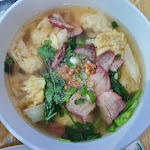

In [32]:
images = images = list(set(random.choices(os.listdir('reviews/California'), k=2)))
image = Image.open(f'reviews/California/{random.choice(images)}')
display(image)
# get_description(image)

### Extract Images

In [ ]:
images = [Image.open(f'reviews/{row.img_filename}').resize((128, 128)) for _, row in df.iterrows()]

In [ ]:
# Genera descripciones de imágenes en lotes y evita sobrecargar la GPU.
def batch_generate_descriptions(images):
    messages = ["What's in the picture? Give me a brief summary" for _ in images]
    prompts = [f"USER: <image>{message}\nASSISTANT:" for message in messages]

    inputs = processor(prompts, images=images, padding=True, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=MAX_NEW_TOKENS)
    generated_texts = processor.batch_decode(outputs, skip_special_tokens=True)

    descriptions = [text.split("ASSISTANT: ")[-1] for text in generated_texts]
    return descriptions


In [ ]:
def save_images_descriptions(df):
    img_description = {}
    batch_size = 16
    image_batch = []
    filenames = []

    for row in tqdm(df.itertuples(), total=len(df), desc="Processing rows"):
        img = Image.open(f'{PREFIX}/{row.img_filename}').resize((128, 128))
        image_batch.append(img)
        filenames.append(row.img_filename)

        # Procesamos el batch cuando alcanza el tamaño especificado ...
        if len(image_batch) == batch_size:
            descriptions = batch_generate_descriptions(image_batch)
            img_description.update({filenames[i]: descriptions[i] for i in range(len(filenames))})
            image_batch.clear()
            filenames.clear()
            torch.cuda.empty_cache()

    # procesamos las imgs restantes
    if image_batch:
        descriptions = batch_generate_descriptions(image_batch)
        img_description.update({filenames[i]: descriptions[i] for i in range(len(filenames))})
        torch.cuda.empty_cache()

    with gzip.open("images_descriptions.json.gz", 'wt', encoding='UTF-8') as zipfile:
        json.dump(img_description, zipfile)


In [ ]:
save_images_descriptions(df)

Processing rows: 100%|██████████| 8038/8038 [2:07:17<00:00,  1.05it/s]


## Download Imgs Descriptions

In [33]:
imgs_descriptions = list(parse("tiny_LLaVa_images_descriptions.json.gz"))[0]

In [34]:
imgs_embeddings = {}
# Generamos un embeddings de tamaño 384.
for key, value in tqdm(imgs_descriptions.items()):
    imgs_embeddings[key] = encoder.encode(value)


100%|██████████| 8038/8038 [02:38<00:00, 50.73it/s]


In [35]:
rev_embeddings = {}
for img_filename, emb in imgs_embeddings.items():
    gmap_id = img_filename.split("/")[-1].split(".")[0]
    rev_id = df[df['gmap_id'] == gmap_id].index[0]
    rev_embeddings[rev_id] = emb

In [36]:
rev_descriptions = {}
for img_filename, description in imgs_descriptions.items():
    gmap_id = img_filename.split("/")[-1].split(".")[0]
    rev_id = df[df['gmap_id'] == gmap_id].index[0]
    rev_descriptions[rev_id] = description



In [37]:
rev_id2info = X.to_dict('index')

In [38]:
user_reviews = {}
for r in X.itertuples():
    if not user_reviews.get(r.user_id):
        user_reviews[r.user_id] = []
    # (review ID, restaurant ID, review's rating, restaurant categories ID)
    user_reviews[r.user_id].append((r.Index, r.rest_id, r.rating, r.categ_id))

In [39]:
allreviews = np.array(list({ u : len(r) for u, r in user_reviews.items()}.values()))

In [40]:
print(len(user_reviews.keys()))

7254


In [41]:
print(allreviews.min())
print(allreviews.mean())
print(allreviews.max())

1
1.1080783016266886
10


In [42]:
count_reviews = Counter(allreviews)
for k, v in sorted(count_reviews.items(), key=lambda x: x[0]):
    print(f'{k:<2} {v:>5}')

1   6700
2    423
3     79
4     27
5     13
6      7
7      3
9      1
10     1


Por cada review de un usuario, creamos el set de train y el de test.
En el caso que un usuario tiene mas de una review, dejamos el 20% de las reviews para test y el resto para train (esto permite que el usuario tenga reviews tanto en testing como en training).
En el otro caso, si el usuario no tiene mas de 1 review, entonces lo dejamos para "entrenar el modelo", ya que no podriamos saber mas info.

In [43]:
train_set, test_set = [], []

for user, reviews in user_reviews.items():
    if len(reviews) <= 1:
        train_set.append(reviews)
    else:
        if 1 < len(reviews) <= 3:           # 2 o 3 reviews
            train_data, test_data = train_test_split(reviews, test_size=0.5, random_state=42)
        elif 3 < len(reviews) <= 5:         # 4 o 5 reviews
            train_data, test_data = train_test_split(reviews, test_size=0.6, random_state=42)
        else:                               # 6 o + reviews
            train_data, test_data = train_test_split(reviews, test_size=0.8, random_state=42)
        train_set.append(train_data)
        test_set.append(test_data)

In [44]:
x_train, x_test = [], []
for d in train_set:
    x_train.extend(d)
for d in test_set:
    x_test.extend(d)

> (review ID, restaurant ID, review's rating, restaurant categories ID)

In [45]:
print('Tamaño de Xtrain: ', len(x_train))
print('Tamaño de Xtest: ', len(x_test))

Tamaño de Xtrain:  7268
Tamaño de Xtest:  770


In [46]:
x_train[0]

(0, 3818, 5, 0)

In [47]:
train_embeddings = list(map(lambda x: rev_embeddings[x[0]], x_train))

In [48]:
test_users = {}
for x in x_test:
    rev_id = x[0]
    user_id = rev_id2info[rev_id]['user_id']
    if not test_users.get(user_id):
        test_users[user_id] = []
    test_users[user_id].append(rev_id)


In [49]:
train_users = {}
for x in x_train:
    rev_id = x[0]
    user_id = rev_id2info[rev_id]['user_id']

    if not train_users.get(user_id):
        train_users[user_id] = []

    train_users[user_id].append(rev_id)

In [50]:
# Usuario de testing y restaurantes evaluados
test_user_items = {}
for user, reviews in test_users.items():
    test_user_items[user] = [(rev_id2info[r]['rest_id'], rev_id2info[r]['rating']) for r in reviews]

# Usuario de training y restaurantes evaluados
train_user_items = {}
for user, reviews in train_users.items():
    train_user_items[user] = [(rev_id2info[r]['rest_id'], rev_id2info[r]['rating']) for r in reviews]

In [51]:
# Mapeamos desde una review a un restaurante
restid2revid = {v['rest_id']: k for k, v in rev_id2info.items()}

In [52]:
def get_restaurant_description(restid):
    '''Retorna una descripcion por default del restaurante en base a su metadata'''
    name = restaurants_dict[restid]['name']
    categories = restaurants_dict[restid]['categories']
    atmosphere = restaurants_dict[restid]['atmosphere']
    offerings = restaurants_dict[restid]['offerings']
    popularfor = restaurants_dict[restid]['popularFor']
    descriptions = restaurants_dict[restid]['descriptions']


    description = f'{name}. {categories}.'

    description += f'. {atmosphere}' if atmosphere is not np.nan else ''
    description += f'. {offerings}' if offerings is not np.nan else ''
    description += f'. {popularfor}' if popularfor is not np.nan else ''
    description += f'. {descriptions}' if descriptions is not np.nan else ''

    return description


Hay restaurantes que no tienen reseñas, como por ejemplo 3410. Asi que, para estos casos, utilizaremos su metadata.

In [53]:
get_restaurant_description(3410)

'The Rusty Rail Saloon, Inc. & Steak House. Bar;Steak house;Lunch restaurant.. Casual;Cozy. Alcohol;Hard liquor;Dancing;Food;Cocktails;Wine;Food at bar;Beer'

In [54]:
restaurants_embeddings = {}
for restid in restaurants_dict.keys():
    if not restid2revid.get(restid):
        embedding = encoder.encode(get_restaurant_description(restid))
    else:
        revid = restid2revid[restid]
        embedding = rev_embeddings[revid]

    if not restaurants_embeddings.get(restid):
        restaurants_embeddings[restid] = []
    restaurants_embeddings[restid].append(embedding)

In [55]:
for restid, embeddings in restaurants_embeddings.items():
    if len(embeddings) == 0:
        print(embeddings)

Para cada restaurante, obtenemos los embeddings relacionados a las reviews realizadas. Si tiene mas de una review, tomamos el promedio.

In [56]:
for restid, embeddings in restaurants_embeddings.items():
    if len(embeddings) == 1:
        restaurants_embeddings[restid] = np.array(embeddings[0])
    else:
        restaurants_embeddings[restid] = np.mean(embeddings, axis=0)

In [57]:
embedding_matrix = np.array([restaurants_embeddings[rest_id] for rest_id in restaurants_dict.keys()])

In [58]:
dataset = Dataset()
dataset.fit(
    users=train_users.keys(),
    items=restaurants_dict.keys(),
    item_features=[f"dim_{i}" for i in range(embedding_matrix.shape[1])]
)

In [66]:
item_features_data = [
    (rest_id, {f"dim_{i}": embedding[i] for i in range(len(embedding))})
    for rest_id, embedding in zip(restaurants_dict.keys(), embedding_matrix)
]
item_features_1 = dataset.build_item_features(item_features_data, normalize=False)

In [67]:
flatmap_train_user_items = []
for user, reviews in train_user_items.items():
    for item, rating in reviews:
        flatmap_train_user_items.append((user, item, rating))

flatmap_test_user_items = []
for user, reviews in test_user_items.items():
    for item, rating in reviews:
        flatmap_test_user_items.append((user, item, rating))

In [68]:
train_interactions, _ = dataset.build_interactions(flatmap_train_user_items)
val_interactions, _ = dataset.build_interactions(flatmap_test_user_items)

In [69]:
num_users, num_items = train_interactions.shape
# mapeamos cada usuario segun la cantidad de items que tiene
scoring_user_ids = np.concatenate([np.full((num_items, ), i) for i in range(num_users)])
# mapeamos cada item repetidamente segun la cantidad de usaurios que lo tiene
scoring_item_ids = np.concatenate([np.arange(num_items) for i in range(num_users)])

user_mappings = dataset.mapping()[0] # diccionario mapeo relacion usuario item
item_mappings = dataset.mapping()[2] # diccionario mapeo relacion item usuario

inv_user_mappings = {value : key for key, value in user_mappings.items()}
inv_item_mappings = {value : key for key, value in item_mappings.items()}


In [63]:
LR = 0.05       # learning rate
N_COMP = 10     # N' de componentes
N_EPOCHS = 5   # Numero de epocas

In [70]:
def fm_eval_n_comp(item_features):
    ncomp_values = [10, 20, 30, 50]
    learning_rate_values = [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1]
    results = []
    max_auc = -np.inf
    best_comp = None
    best_lr = None

    for n_comp in ncomp_values:
        for lr in learning_rate_values:
            model = LightFM(no_components=n_comp, learning_rate=lr, loss='warp')

            for epoch in range(N_EPOCHS):
                model.fit_partial(train_interactions, epochs=1, item_features=item_features)

            auc = auc_score(model, val_interactions, item_features=item_features).mean()
            print(f'Componentes: {n_comp}, Learning Rate: {lr}, AUC: {auc}')
            results.append((n_comp, lr, auc))

            if auc > max_auc:
                max_auc = auc
                best_comp = n_comp
                best_lr = lr

    print(f'\nMejor Componente: {best_comp}')
    print(f'Mejor Learning Rate: {best_lr}')
    print(f'Max AUC: {max_auc}')


    results = np.array(results)
    for lr in learning_rate_values:
        aucs_for_lr = results[results[:, 1] == lr][:, 2]
        plt.plot(ncomp_values, aucs_for_lr, label=f'LR={lr}')

    plt.xlabel('Número de Componentes')
    plt.ylabel('AUC')
    plt.title('AUC vs Número de Componentes para diferentes tasas de aprendizaje')
    plt.legend()
    plt.grid(True)
    plt.show()

    return results

In [71]:
def fm_train(lr=LR, no_comp=N_COMP, epochs=N_EPOCHS, k=10):

    model_fm = LightFM(loss='warp')

    model_fm.fit(train_interactions, epochs=epochs, item_features=item_features, verbose=True)

    fm_reclist = {}
    for user_id in test_users.keys():
        scores = model_fm.predict(dataset.mapping()[0][user_id], np.arange(dataset.interactions_shape()[1]))
        top_10 = np.argsort(-scores)[:k]
        recommendations = np.array(list(restaurants_dict.keys()))[top_10]
        fm_reclist[user_id] = recommendations

    return fm_reclist


## Model LightFM + LLaVA

### Sensitivity Analysis

Componentes: 10, Learning Rate: 1e-05, AUC: 0.5015890002250671
Componentes: 10, Learning Rate: 0.0001, AUC: 0.4924429953098297
Componentes: 10, Learning Rate: 0.001, AUC: 0.43352818489074707
Componentes: 10, Learning Rate: 0.01, AUC: 0.4828778803348541
Componentes: 10, Learning Rate: 0.05, AUC: 0.5099470615386963
Componentes: 10, Learning Rate: 0.1, AUC: 0.49710214138031006
Componentes: 20, Learning Rate: 1e-05, AUC: 0.5027312636375427
Componentes: 20, Learning Rate: 0.0001, AUC: 0.4766305983066559
Componentes: 20, Learning Rate: 0.001, AUC: 0.46129804849624634
Componentes: 20, Learning Rate: 0.01, AUC: 0.5277742147445679
Componentes: 20, Learning Rate: 0.05, AUC: 0.4913686513900757
Componentes: 20, Learning Rate: 0.1, AUC: 0.5064588189125061
Componentes: 30, Learning Rate: 1e-05, AUC: 0.5048552751541138
Componentes: 30, Learning Rate: 0.0001, AUC: 0.4572855532169342
Componentes: 30, Learning Rate: 0.001, AUC: 0.4701386094093323
Componentes: 30, Learning Rate: 0.01, AUC: 0.528117239475

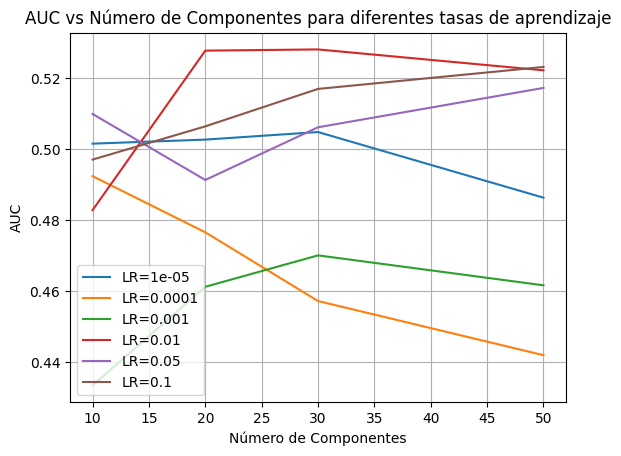

array([[1.00000000e+01, 1.00000000e-05, 5.01589000e-01],
       [1.00000000e+01, 1.00000000e-04, 4.92442995e-01],
       [1.00000000e+01, 1.00000000e-03, 4.33528185e-01],
       [1.00000000e+01, 1.00000000e-02, 4.82877880e-01],
       [1.00000000e+01, 5.00000000e-02, 5.09947062e-01],
       [1.00000000e+01, 1.00000000e-01, 4.97102141e-01],
       [2.00000000e+01, 1.00000000e-05, 5.02731264e-01],
       [2.00000000e+01, 1.00000000e-04, 4.76630598e-01],
       [2.00000000e+01, 1.00000000e-03, 4.61298048e-01],
       [2.00000000e+01, 1.00000000e-02, 5.27774215e-01],
       [2.00000000e+01, 5.00000000e-02, 4.91368651e-01],
       [2.00000000e+01, 1.00000000e-01, 5.06458819e-01],
       [3.00000000e+01, 1.00000000e-05, 5.04855275e-01],
       [3.00000000e+01, 1.00000000e-04, 4.57285553e-01],
       [3.00000000e+01, 1.00000000e-03, 4.70138609e-01],
       [3.00000000e+01, 1.00000000e-02, 5.28117239e-01],
       [3.00000000e+01, 5.00000000e-02, 5.06199718e-01],
       [3.00000000e+01, 1.00000

In [72]:
fm_eval_n_comp(item_features_1)

### Evaluation and examples

In [74]:
fm_reclist10 = fm_train(lr=30, no_comp=0.01, epochs=5, k=10)
evaluate_model(fm_reclist10, n=10)

Epoch: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


MAP@10: 0.005776173285198559
nDCG@10: 0.04844071324626926
Recall@10: 0.047653429602888084
Precision@10: 0.005595667870036103
MRR@10: 0.026125293679445306
Novelty@10: 6.690928966613188
Diversity@10: 0.9384476534296022


In [76]:
fm_reclist20 = fm_train(lr=30, no_comp=0.01, epochs=5, k=20)
evaluate_model(fm_reclist20, n=20)

Epoch: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


MAP@20: 0.001895306859205777
nDCG@20: 0.027580726044335414
Recall@20: 0.025631768953068592
Precision@20: 0.0018050541516245495
MRR@20: 0.014966643443747757
Novelty@20: 7.506286942168194
Diversity@20: 0.8973826714801421


In [84]:
fm_reclist30 = fm_train(lr=30, no_comp=0.01, epochs=5, k=30)
evaluate_model(fm_reclist30, n=30)

Epoch: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


MAP@30: 0.00252707581227437
nDCG@30: 0.05864261688295018
Recall@30: 0.057581227436823104
Precision@30: 0.0024669073405535515
MRR@30: 0.02459737468155867
Novelty@30: 7.546579928501338
Diversity@30: 0.8741877256317676


In [77]:
# Buscamos diversos usuarios
user1, user2, user3 = None, None, None
while not (user1 and user2 and user3):
    for user, recs in test_users.items():
        if user1 == None and 1 <= len(recs) < 4:
            user1 = user
        if user2 == None and 4 <= len(recs) < 6:
            user2 = user
        if user3 == None and 8 <= len(recs):
            user3 = user

#### User 1

In [80]:
show_recommendations(user=user1, reclist=fm_reclist10[user1])

PERFIL DEL USUARIO
- Palabras claves:
   bigger, food, got, great, im
   juices, later, lot, main, near
   number, pay, pomegranate, sides, sitting
   squeezed, stomach, togo, tonight, way
- Sentimiendo dominante:  positive
- Lugares visitados:  Texas
- Caracteristicas de restaurantes visitados:
   Comfort food, Healthy options

10 RECOMENDACIONES


,name,description,categories
0,Aki Fresh Mex,NaN,Restaurant
1,Starbucks,Seattle-based coffeehouse chain known for its ...,Breakfast restaurant;Coffee shop;Coffee store;...
2,Curry Craft - Nordahl,NaN,Modern Indian restaurant;Restaurant;Indian res...
3,China Cook,NaN,Chinese restaurant
4,Tortilleria Zeamays,NaN,Mexican restaurant;Mexican grocery store
5,The Latin Chef Liberty Station,NaN,Peruvian restaurant
6,Princeville Makai Golf Club,NaN,Resort hotel;Golf instructor;Golf club;Golf co...
7,Tacos & More,NaN,Mexican restaurant
8,LFM - Local Foods Market,Laid-back venue for wine & health-conscious bi...,Restaurant
9,Cazadores,Easygoing option featuring everyday Mexican pl...,Mexican restaurant


In [81]:
show_recommendations(user=user1, reclist=fm_reclist20[user1])

PERFIL DEL USUARIO
- Palabras claves:
   bigger, food, got, great, im
   juices, later, lot, main, near
   number, pay, pomegranate, sides, sitting
   squeezed, stomach, togo, tonight, way
- Sentimiendo dominante:  positive
- Lugares visitados:  Texas
- Caracteristicas de restaurantes visitados:
   Comfort food, Healthy options

20 RECOMENDACIONES


,name,description,categories
0,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
1,Von's Chicken,NaN,Chicken restaurant
2,Blaze Pizza,"Hip counter-serve pizzeria dishing up crispy, ...",Family restaurant;Pizza Takeout;Pizza restaurant
3,QDOBA Mexican Eats,"Mexican chain for counter-serve, custom burrit...",Caterer;Mexican restaurant;Delivery service;Bo...
4,Soho Cafe,Hong Kong-style eats & American fare in a casu...,Cafe;Chinese restaurant;Restaurant
5,Mint & Liberty Diner,NaN,Restaurant
6,Chick-fil-A,"Fast-food chain serving chicken sandwiches, st...",Caterer;Breakfast restaurant;Delivery service;...
7,Wendy's,Fast-food burger chain serving sides such as c...,Breakfast restaurant;Hamburger restaurant;Rest...
8,Tony Mariscos Restaurant,NaN,Seafood restaurant;Mexican restaurant
9,Eatuscany Caffe,Light Italian fare & gelato options are served...,Italian restaurant;Restaurant


#### User 2

In [82]:
show_recommendations(user=user2, reclist=fm_reclist10[user2])

PERFIL DEL USUARIO
- Palabras claves:
   81, friendly, patio, plus, recommendations
   regular, rice, roasted, rotisserie, salad
   smores, spinach, spot, staff, stop
   tomato, trailer, travel, traveling, weekend
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Coffee, Small plates, Cocktails, Quick bite, Beer
   Happy-hour food, Late-night food, Happy-hour drinks, Kids' menu, Comfort food
   Vegetarian options, Healthy options, Wine, Alcohol, Spirits

10 RECOMENDACIONES


,name,description,categories
0,Domino's Pizza,Delivery/carryout chain offering a wide range ...,Takeout Restaurant;Pizza delivery;Pizza Takeou...
1,Papa John's Pizza,Take-out/delivery chain offering classic & spe...,Delivery Restaurant;Pizza restaurant
2,Pizza Hut,Family-friendly chain known for its made-to-or...,Takeout Restaurant;Delivery Restaurant;Deliver...
3,Dunkin',Long-running chain serving signature breakfast...,Breakfast restaurant;Coffee shop;Takeout Resta...
4,Bright Night昼伏夜出,NaN,Diner;Restaurant
5,McDonald's,"Classic, long-running fast-food chain known fo...",Breakfast restaurant;Coffee shop;Sandwich shop...
6,Wawa,Convenience store chain known for sandwiches &...,Breakfast restaurant;Coffee shop;Cheesesteak r...
7,Jersey Mike's Subs,New Jersey-based counter-serve sandwich chain ...,Caterer;Takeout Restaurant;Sandwich shop;Deli;...
8,Noodles and Company,Counter-serve chain offering international noo...,Takeout Restaurant;Takeout restaurant;Down hom...
9,Fitties BBQ,"Tiny roadside BBQ haunt offering ribs, brisket...",Barbecue restaurant


In [83]:
show_recommendations(user=user2, reclist=fm_reclist20[user2])

PERFIL DEL USUARIO
- Palabras claves:
   81, friendly, patio, plus, recommendations
   regular, rice, roasted, rotisserie, salad
   smores, spinach, spot, staff, stop
   tomato, trailer, travel, traveling, weekend
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Coffee, Small plates, Cocktails, Quick bite, Beer
   Happy-hour food, Late-night food, Happy-hour drinks, Kids' menu, Comfort food
   Vegetarian options, Healthy options, Wine, Alcohol, Spirits

20 RECOMENDACIONES


,name,description,categories
0,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
1,Marin Pizza,NaN,Pizza restaurant
2,Papa John's Pizza,Take-out/delivery chain offering classic & spe...,Delivery Restaurant;Pizza restaurant
3,Pizza Hut,Family-friendly chain known for its made-to-or...,Takeout Restaurant;Delivery Restaurant;Deliver...
4,Dunkin',Long-running chain serving signature breakfast...,Breakfast restaurant;Coffee shop;Takeout Resta...
5,Los Mariscos La Puente,NaN,Seafood restaurant;Mexican restaurant
6,Wingstop,Casual counter-serve chain serving a variety o...,Chicken wings restaurant;Chicken restaurant
7,Chipotle Mexican Grill,"Fast-food chain offering Mexican fare, includi...",Caterer;Mexican restaurant;Fast food restaurant
8,Chick-fil-A,"Fast-food chain serving chicken sandwiches, st...",Caterer;Breakfast restaurant;Delivery service;...
9,Guadalajara grill taco shop,NaN,Restaurant


#### User 3

In [85]:
show_recommendations(user=user3, reclist=fm_reclist10[user3])

PERFIL DEL USUARIO
- Palabras claves:
   awesome, chef, delicious, dishes, empanadas
   especially, fantastic, food, good, latin
   perfect, pizzas, salmon, spot, staff
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Happy hour drinks, Happy hour food, Coffee, Small plates, Cocktails
   Beer, Quick bite, Hard liquor, Kids' menu, Comfort food
   Vegetarian options, Healthy options, Wine, Alcohol

10 RECOMENDACIONES


,name,description,categories
0,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
1,Taco Bell,Fast-food chain serving Mexican-inspired fare ...,Breakfast restaurant;Takeout Restaurant;Mexica...
2,Domino's Pizza,Delivery/carryout chain offering a wide range ...,Takeout Restaurant;Pizza delivery;Pizza Takeou...
3,Papa John's Pizza,Take-out/delivery chain offering classic & spe...,Delivery Restaurant;Pizza restaurant
4,Pizza Hut,Family-friendly chain known for its made-to-or...,Takeout Restaurant;Delivery Restaurant;Deliver...
5,Dunkin',Long-running chain serving signature breakfast...,Breakfast restaurant;Coffee shop;Takeout Resta...
6,Wingstop,Casual counter-serve chain serving a variety o...,Chicken wings restaurant;Chicken restaurant
7,McDonald's,"Classic, long-running fast-food chain known fo...",Breakfast restaurant;Coffee shop;Sandwich shop...
8,Jersey Mike's Subs,New Jersey-based counter-serve sandwich chain ...,Caterer;Takeout Restaurant;Sandwich shop;Deli;...
9,Noodles and Company,Counter-serve chain offering international noo...,Takeout Restaurant;Takeout restaurant;Down hom...


In [86]:
show_recommendations(user=user3, reclist=fm_reclist20[user3])

PERFIL DEL USUARIO
- Palabras claves:
   awesome, chef, delicious, dishes, empanadas
   especially, fantastic, food, good, latin
   perfect, pizzas, salmon, spot, staff
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Happy hour drinks, Happy hour food, Coffee, Small plates, Cocktails
   Beer, Quick bite, Hard liquor, Kids' menu, Comfort food
   Vegetarian options, Healthy options, Wine, Alcohol

20 RECOMENDACIONES


,name,description,categories
0,Domino's Pizza,Delivery/carryout chain offering a wide range ...,Takeout Restaurant;Pizza delivery;Pizza Takeou...
1,Starbucks,Seattle-based coffeehouse chain known for its ...,Breakfast restaurant;Coffee shop;Coffee store;...
2,Pizza Hut,Family-friendly chain known for its made-to-or...,Takeout Restaurant;Delivery Restaurant;Deliver...
3,Dunkin',Long-running chain serving signature breakfast...,Breakfast restaurant;Coffee shop;Takeout Resta...
4,Wingstop,Casual counter-serve chain serving a variety o...,Chicken wings restaurant;Chicken restaurant
5,Hyde Lounge at STAPLES Center,Classic & creative cocktails offered in a soph...,Wine bar;Lounge;Event venue;Cocktail bar;Bar &...
6,Chipotle Mexican Grill,"Fast-food chain offering Mexican fare, includi...",Caterer;Mexican restaurant;Fast food restaurant
7,Jersey Mike's Subs,New Jersey-based counter-serve sandwich chain ...,Caterer;Takeout Restaurant;Sandwich shop;Deli;...
8,ITO Mojitos y Cafecitos,NaN,Gastropub;Cocktail bar;Restaurant
9,IHOP,Long-standing chain serving a wide variety of ...,Family restaurant;Breakfast restaurant;America...


## Model LightFM + allMiniLLM

In [87]:
df['text_length'] = len(df['text'])

In [88]:
text_lengths = np.array([len(row.text) for row in df.itertuples()])
print(text_lengths.min())
print(text_lengths.mean())
print(text_lengths.max())

1
267.99838268225926
3899


In [89]:
encoded_descriptions = {}
for row in tqdm(df.itertuples(), total=df.shape[0]):
    rev_id = row.Index
    rev_text = row.text
    encoded_descriptions[rev_id] = encoder.encode(rev_text)

100%|██████████| 8038/8038 [02:14<00:00, 59.55it/s]


Construimos los embeddings asociados a las descripciones de cada review y ademas, la matriz que relaciona cada restaurante con su embeddings (relativo a las reviews).

In [90]:
restaurants_embeddings_2 = {}

for restid in restaurants_dict.keys():
    if not restid2revid.get(restid):
        embedding = encoder.encode(get_restaurant_description(restid))
    else:
        revid = restid2revid[restid]
        embedding = encoded_descriptions[revid]

    if not restaurants_embeddings_2.get(restid):
        restaurants_embeddings_2[restid] = []

    restaurants_embeddings_2[restid].append(embedding)

for restid, embeddings in restaurants_embeddings_2.items():
    if len(embeddings) == 1:
        restaurants_embeddings_2[restid] = np.array(embeddings[0])
    else:
        restaurants_embeddings_2[restid] = np.mean(embeddings, axis=0)

embedding_matrix_2 = np.array([restaurants_embeddings_2[rest_id] for rest_id in restaurants_dict.keys()])

In [91]:
dataset = Dataset()
dataset.fit(
    users=train_users.keys(),
    items=restaurants_dict.keys(),
    item_features=[f"dim_{i}" for i in range(embedding_matrix_2.shape[1])]
)

In [92]:
item_features_data = [
    (rest_id, {f"dim_{i}": embedding[i] for i in range(len(embedding))})
    for rest_id, embedding in zip(restaurants_dict.keys(), embedding_matrix_2)
]
item_features_2 = dataset.build_item_features(item_features_data, normalize=False)

In [93]:
flatmap_train_user_items = []
for user, reviews in train_user_items.items():
    for item, rating in reviews:
        flatmap_train_user_items.append((user, item, rating))

flatmap_test_user_items = []
for user, reviews in test_user_items.items():
    for item, rating in reviews:
        flatmap_test_user_items.append((user, item, rating))

In [94]:
train_interactions, _ = dataset.build_interactions(flatmap_train_user_items)
val_interactions, _ = dataset.build_interactions(flatmap_test_user_items)

num_users, num_items = train_interactions.shape
scoring_user_ids = np.concatenate([np.full((num_items, ), i) for i in range(num_users)])
scoring_item_ids = np.concatenate([np.arange(num_items) for i in range(num_users)])

user_mappings = dataset.mapping()[0] # diccionario mapeo relacion usuario item
item_mappings = dataset.mapping()[2] # diccionario mapeo relacion item usuario

inv_user_mappings = {value : key for key, value in user_mappings.items()}
inv_item_mappings = {value : key for key, value in item_mappings.items()}


### Sensitivity Analysis

Componentes: 10, Learning Rate: 1e-05, AUC: 0.5000098347663879
Componentes: 10, Learning Rate: 0.0001, AUC: 0.49541807174682617
Componentes: 10, Learning Rate: 0.001, AUC: 0.4847276508808136
Componentes: 10, Learning Rate: 0.01, AUC: 0.47572100162506104
Componentes: 10, Learning Rate: 0.05, AUC: 0.5317473411560059
Componentes: 10, Learning Rate: 0.1, AUC: 0.5196137428283691
Componentes: 20, Learning Rate: 1e-05, AUC: 0.49983805418014526
Componentes: 20, Learning Rate: 0.0001, AUC: 0.4762660264968872
Componentes: 20, Learning Rate: 0.001, AUC: 0.4661638140678406
Componentes: 20, Learning Rate: 0.01, AUC: 0.4775111973285675
Componentes: 20, Learning Rate: 0.05, AUC: 0.5480996966362
Componentes: 20, Learning Rate: 0.1, AUC: 0.5451758503913879
Componentes: 30, Learning Rate: 1e-05, AUC: 0.5140042901039124
Componentes: 30, Learning Rate: 0.0001, AUC: 0.46634143590927124
Componentes: 30, Learning Rate: 0.001, AUC: 0.47358202934265137
Componentes: 30, Learning Rate: 0.01, AUC: 0.4638630151748

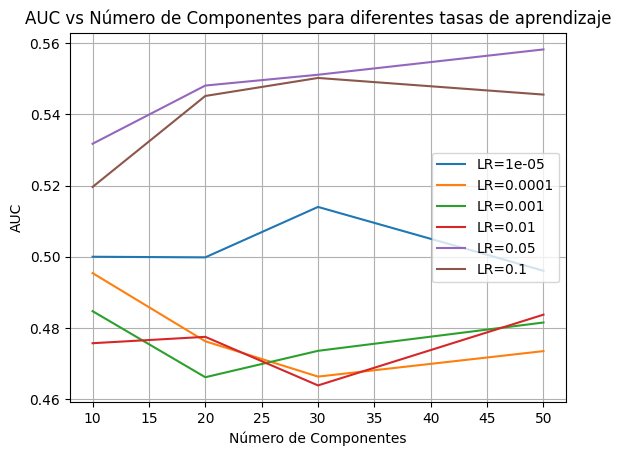

array([[1.00000000e+01, 1.00000000e-05, 5.00009835e-01],
       [1.00000000e+01, 1.00000000e-04, 4.95418072e-01],
       [1.00000000e+01, 1.00000000e-03, 4.84727651e-01],
       [1.00000000e+01, 1.00000000e-02, 4.75721002e-01],
       [1.00000000e+01, 5.00000000e-02, 5.31747341e-01],
       [1.00000000e+01, 1.00000000e-01, 5.19613743e-01],
       [2.00000000e+01, 1.00000000e-05, 4.99838054e-01],
       [2.00000000e+01, 1.00000000e-04, 4.76266026e-01],
       [2.00000000e+01, 1.00000000e-03, 4.66163814e-01],
       [2.00000000e+01, 1.00000000e-02, 4.77511197e-01],
       [2.00000000e+01, 5.00000000e-02, 5.48099697e-01],
       [2.00000000e+01, 1.00000000e-01, 5.45175850e-01],
       [3.00000000e+01, 1.00000000e-05, 5.14004290e-01],
       [3.00000000e+01, 1.00000000e-04, 4.66341436e-01],
       [3.00000000e+01, 1.00000000e-03, 4.73582029e-01],
       [3.00000000e+01, 1.00000000e-02, 4.63863015e-01],
       [3.00000000e+01, 5.00000000e-02, 5.51137865e-01],
       [3.00000000e+01, 1.00000

In [ ]:
fm_eval_n_comp(item_features_2)

### Evaluation and Examples

In [95]:
fm_basic_reclist10 = fm_train(lr=50, no_comp=0.05, epochs=5, k=10)
evaluate_model(fm_basic_reclist10, n=10)

Epoch: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


MAP@10: 0.0045126353790613735
nDCG@10: 0.037019386837383435
Recall@10: 0.03682310469314079
Precision@10: 0.0045126353790613735
MRR@10: 0.01976534296028881
Novelty@10: 6.8050997868061565
Diversity@10: 0.9395306859205762


In [97]:
fm_basic_reclist20 = fm_train(lr=50, no_comp=0.05, epochs=5, k=20)
evaluate_model(fm_basic_reclist20, n=20)

Epoch: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


MAP@20: 0.0032490974729241897
nDCG@20: 0.0494601679165794
Recall@20: 0.04915764139590854
Precision@20: 0.0031588447653429622
MRR@20: 0.023204840264977065
Novelty@20: 7.176193437726077
Diversity@20: 0.8965703971119132


In [111]:
fm_basic_reclist30 = fm_train(lr=50, no_comp=0.05, epochs=5, k=30)
evaluate_model(fm_basic_reclist30, n=30)

Epoch: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


MAP@30: 0.0027075812274368256
nDCG@30: 0.06279967873639655
Recall@30: 0.0621540312876053
Precision@30: 0.002647412755716007
MRR@30: 0.02092727757713588
Novelty@30: 7.514411714360017
Diversity@30: 0.864500601684715


#### User 1

In [101]:
show_recommendations(user=user1, reclist=fm_basic_reclist10[user1])

PERFIL DEL USUARIO
- Palabras claves:
   bigger, food, got, great, im
   juices, later, lot, main, near
   number, pay, pomegranate, sides, sitting
   squeezed, stomach, togo, tonight, way
- Sentimiendo dominante:  positive
- Lugares visitados:  Texas
- Caracteristicas de restaurantes visitados:
   Comfort food, Healthy options

10 RECOMENDACIONES


,name,description,categories
0,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
1,Taco Bell,Fast-food chain serving Mexican-inspired fare ...,Breakfast restaurant;Takeout Restaurant;Mexica...
2,Chick-fil-A,"Fast-food chain serving chicken sandwiches, st...",Caterer;Breakfast restaurant;Delivery service;...
3,Thai Mango,NaN,Thai restaurant
4,Glasskey Restaurant & Take-Out,NaN,Takeout Restaurant
5,Yakitori Ando,NaN,Yakitori restaurant
6,Chengs Chop Suey House,NaN,Chinese restaurant
7,Wagaya,Compact restaurant featuring an array of ramen...,Ramen restaurant
8,The Sea Captain,NaN,Seafood restaurant
9,House Of Chou,Eclectic Chinese fare & a few Thai specialties...,Chinese restaurant;Restaurant


In [102]:
show_recommendations(user=user1, reclist=fm_basic_reclist20[user1])

PERFIL DEL USUARIO
- Palabras claves:
   bigger, food, got, great, im
   juices, later, lot, main, near
   number, pay, pomegranate, sides, sitting
   squeezed, stomach, togo, tonight, way
- Sentimiendo dominante:  positive
- Lugares visitados:  Texas
- Caracteristicas de restaurantes visitados:
   Comfort food, Healthy options

20 RECOMENDACIONES


,name,description,categories
0,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
1,Guanatos Tacos,NaN,Restaurant
2,Mimosas,NaN,Restaurant
3,Let’s Yolk About It,NaN,Brunch restaurant
4,Domino's Pizza,Delivery/carryout chain offering a wide range ...,Takeout Restaurant;Pizza delivery;Pizza Takeou...
5,Starbucks,Seattle-based coffeehouse chain known for its ...,Breakfast restaurant;Coffee shop;Coffee store;...
6,Papa John's Pizza,Take-out/delivery chain offering classic & spe...,Delivery Restaurant;Pizza restaurant
7,Shell,NaN,Fast food restaurant;Auto repair shop;Gas stat...
8,Nekter Juice Bar,Local juice-bar chain offering specialty drink...,Breakfast restaurant;Juice shop;Cafe;Health fo...
9,The Best Restaurant,NaN,Takeout Restaurant;Haitian restaurant;American...


#### User 2

In [103]:
show_recommendations(user=user2, reclist=fm_basic_reclist10[user2])

PERFIL DEL USUARIO
- Palabras claves:
   81, friendly, patio, plus, recommendations
   regular, rice, roasted, rotisserie, salad
   smores, spinach, spot, staff, stop
   tomato, trailer, travel, traveling, weekend
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Coffee, Small plates, Cocktails, Quick bite, Beer
   Happy-hour food, Late-night food, Happy-hour drinks, Kids' menu, Comfort food
   Vegetarian options, Healthy options, Wine, Alcohol, Spirits

10 RECOMENDACIONES


,name,description,categories
0,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
1,Starbucks,Seattle-based coffeehouse chain known for its ...,Breakfast restaurant;Coffee shop;Coffee store;...
2,Papa John's Pizza,Take-out/delivery chain offering classic & spe...,Delivery Restaurant;Pizza restaurant
3,Chipotle Mexican Grill,"Fast-food chain offering Mexican fare, includi...",Caterer;Mexican restaurant;Fast food restaurant
4,Chick-fil-A,"Fast-food chain serving chicken sandwiches, st...",Caterer;Breakfast restaurant;Delivery service;...
5,Wawa,Convenience store chain known for sandwiches &...,Breakfast restaurant;Coffee shop;Cheesesteak r...
6,Popeyes Louisiana Kitchen,Louisiana-inspired fast-food chain known for i...,Fast food restaurant;Cajun restaurant;Chicken ...
7,Jersey Mike's Subs,New Jersey-based counter-serve sandwich chain ...,Caterer;Takeout Restaurant;Sandwich shop;Deli;...
8,Applebee's Grill + Bar,Full-service chain bar & grill providing heart...,Diner;Hamburger restaurant;Steak house;Family ...
9,QuikTrip,"Convenience store chain supplying snacks, sand...",Breakfast restaurant;Gas station;Beer store;Sn...


In [104]:
show_recommendations(user=user2, reclist=fm_basic_reclist20[user2])

PERFIL DEL USUARIO
- Palabras claves:
   81, friendly, patio, plus, recommendations
   regular, rice, roasted, rotisserie, salad
   smores, spinach, spot, staff, stop
   tomato, trailer, travel, traveling, weekend
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Coffee, Small plates, Cocktails, Quick bite, Beer
   Happy-hour food, Late-night food, Happy-hour drinks, Kids' menu, Comfort food
   Vegetarian options, Healthy options, Wine, Alcohol, Spirits

20 RECOMENDACIONES


,name,description,categories
0,Auntie Anne's,Global chain of counters dispensing sweet & sa...,Cafe;Pretzel store;Restaurant;Bakery
1,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
2,Five Guys,"Fast-food chain with made-to-order burgers, fr...",Hot dog restaurant;Hot dog stand;Hamburger res...
3,Taco Bell,Fast-food chain serving Mexican-inspired fare ...,Breakfast restaurant;Takeout Restaurant;Mexica...
4,QDOBA Mexican Eats,"Mexican chain for counter-serve, custom burrit...",Caterer;Mexican restaurant;Delivery service;Bo...
5,Domino's Pizza,Delivery/carryout chain offering a wide range ...,Takeout Restaurant;Pizza delivery;Pizza Takeou...
6,Pizza Hut,Family-friendly chain known for its made-to-or...,Takeout Restaurant;Delivery Restaurant;Deliver...
7,Dunkin',Long-running chain serving signature breakfast...,Breakfast restaurant;Coffee shop;Takeout Resta...
8,Cold Stone Creamery,Ice cream chain offering design-your-own creat...,Frozen yogurt shop;Ice cream shop;Dessert rest...
9,Shell,NaN,Fast food restaurant;Auto repair shop;Gas stat...


#### User 3

In [105]:
show_recommendations(user=user3, reclist=fm_basic_reclist10[user3])

PERFIL DEL USUARIO
- Palabras claves:
   awesome, chef, delicious, dishes, empanadas
   especially, fantastic, food, good, latin
   perfect, pizzas, salmon, spot, staff
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Happy hour drinks, Happy hour food, Coffee, Small plates, Cocktails
   Beer, Quick bite, Hard liquor, Kids' menu, Comfort food
   Vegetarian options, Healthy options, Wine, Alcohol

10 RECOMENDACIONES


,name,description,categories
0,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
1,Domino's Pizza,Delivery/carryout chain offering a wide range ...,Takeout Restaurant;Pizza delivery;Pizza Takeou...
2,Pizza Hut,Family-friendly chain known for its made-to-or...,Takeout Restaurant;Delivery Restaurant;Deliver...
3,Wingstop,Casual counter-serve chain serving a variety o...,Chicken wings restaurant;Chicken restaurant
4,Wokshop by Xi'an,NaN,Fusion restaurant;Dim sum restaurant;Asian res...
5,Sushi Villa,NaN,Sushi restaurant
6,Panda Express,"Fast-food chain for Chinese standards, includi...",Takeout Restaurant;Asian restaurant;Chinese re...
7,Wawa,Convenience store chain known for sandwiches &...,Breakfast restaurant;Coffee shop;Cheesesteak r...
8,MOCA Asian Cuisine,NaN,Restaurant
9,PUPUSERIA Y Taqueria Las Brasas,NaN,Fast food restaurant


In [106]:
show_recommendations(user=user3, reclist=fm_basic_reclist20[user3])

PERFIL DEL USUARIO
- Palabras claves:
   awesome, chef, delicious, dishes, empanadas
   especially, fantastic, food, good, latin
   perfect, pizzas, salmon, spot, staff
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Happy hour drinks, Happy hour food, Coffee, Small plates, Cocktails
   Beer, Quick bite, Hard liquor, Kids' menu, Comfort food
   Vegetarian options, Healthy options, Wine, Alcohol

20 RECOMENDACIONES


,name,description,categories
0,Paradiso Fruit,NaN,Restaurant
1,Whistlin' Dixie,NaN,Restaurant
2,Ponce's Tacos,NaN,Taco restaurant
3,Pizza Hut,Family-friendly chain known for its made-to-or...,Takeout Restaurant;Delivery Restaurant;Deliver...
4,Wingstop,Casual counter-serve chain serving a variety o...,Chicken wings restaurant;Chicken restaurant
5,Chipotle Mexican Grill,"Fast-food chain offering Mexican fare, includi...",Caterer;Mexican restaurant;Fast food restaurant
6,Guatepan Bakery 2,NaN,Guatemalan restaurant;Bakery
7,McDonald's,"Classic, long-running fast-food chain known fo...",Breakfast restaurant;Coffee shop;Sandwich shop...
8,Batidos cubanos,NaN,Cuban restaurant
9,The Hawaii Fudge Company,NaN,Hawaiian restaurant


# Fuentes

- Kosse, R. (2023). Building a Recommender System with Text Embeddings using Python and LightFM. _Medium_. [link](https://medium.com/@r.kosse/building-a-embedding-recommender-system-with-python-and-lightfm-e18b3df16e88)